# Metpy로 지도에 지상관측자료 기입하기
- https://mesonet.agron.iastate.edu/request/download.phtml?network=KR__ASOS 에서 자료 내려받기
- pandas 패키지를 이용해 자료를 읽고 처리하기
- Metpy 패키지를 이용해 자료를 지상전문 기입 방식에 맞게 처리하기
- Matplotlib과 Cartopy 패키지를 이용해 이미지 생성, 지도 표출하고 자료 기입하기

# SYNOP 자료 
- https://data.kma.go.kr/data/ogd/selectGtsRltmList.do?pgmNo=658
기상자료개방포털, 기간과 관측소를 정해서 SYNOP 자료를 쉽게 내려받을 수 있지만, 운량과 현재일기 정보가 없음
- https://mesonet.agron.iastate.edu/request/download.phtml?network=KR__ASOS
아이오와 주립대 아카이브, 기간과 관측소를 정해서 ASOS 자료를 쉽게 내려받을 수 있지만, 운량 정보가 불확실하고 해면기압 관측이 부족함
- http://www.meteomanz.com/index?l=1
SYNOP 자료를 기간과 위치를 정해서 전문형태로도, 표 형태로도 내려받을 수 있음

# Station index number
- https://www.wmo.int/pages/prog/www/ois/volume-a/vola-hist-home.htm
에서 latest version의 txt로 내려받을 수 있음
- IndexNbr가 47108과 같은 것이고, Hp가 관측소의 고도 [m]임
- 아이오와 주립대 아카이브의 ASOS 자료의 경우 station metadata를 내려받을 수 있음

In [1]:
# 필요한 패키지 임포트
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

from metpy.calc import wind_components, altimeter_to_sea_level_pressure
from metpy.cbook import get_test_data
from metpy.plots import StationPlot,StationPlotLayout, wx_code_map
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units

In [2]:
# 자료 읽기
# 자료의 위치와 자료 파일의 이름을 써줍니다
path1 = r'C:\Users\DongGyu_Hyeon\Downloads\asos.csv'
path2 = r'C:\Users\DongGyu_Hyeon\Downloads\asos (2).csv'
path3 = r'C:\Users\DongGyu_Hyeon\Downloads\asos (3).csv'

# 자료를 확인하면 각 열이
# 관측지점*, 시간*, 경도*, 위도*, 고도*, 기온(화씨)*,
# 이슬점온도(화씨)*, 상대습도, 풍향*, 풍속(knots)*, 누적강수, 
# alti, 해면기압(hPa)*, 시정, 돌풍, 운량1*, 
# 운량2*, 운량3*, 운량4, 운고1, 운고2, 
# 운고3, 운고4, 현재 일기*, 체감기온,
# ... 을 나타내고 *표시한 변수만을 사용할 예정!

cols = (0,1,2,3,4,5,6,8,9,11,12,15,16,17,23)
var = ['stid','time','lon','lat','elevation','air_temperature','dew_point_temperature',\
        'wind_dir','wind_speed','altimeter','sea_level_pressure',\
        'sky1','sky2','sky3','weather']

kr = pd.read_csv(path1, usecols=cols, names=var, na_values='M', header=0)
stid = ['QEP', 'RKPC', 'RKPK','RKSO', 'RKSY'] # 광주, 강릉, 부산, 제주, 서울
kr.set_index('stid', inplace=True)
kr = kr.loc[stid]
kr = kr.reset_index()

jp = pd.read_csv(path2, usecols=cols, names=var, na_values='M', header=0)
stid = ['ROIG', 'ROAH', 'RJFG', 'RJAW',  # 이시가키, 오키나와, 타네가시마, 이와지마
         'RJFK', 'RJFF', 'RJOS', 'RJOW', 'RJOO',  #가고시마, 후쿠오카, 토쿠시마, 이와미, 오사카
         'RJNG', 'RJTF', 'RJSF', 'RJNT', 'RJSS',  # 기푸, 도쿄, 후쿠시마, 토야마, 센다이
         'RJSK', 'RJSA', 'RJCC']                 # 아키타, 아오모리, 삿포로
jp.set_index('stid', inplace=True)
jp = jp.loc[stid]
jp = jp.reset_index()

cn = pd.read_csv(path3, usecols=cols, names=var, na_values='M', header=0)


df = pd.concat([kr,jp,cn])
df.set_index('time', inplace=True)
df = df.loc['2021-09-21 00:00']
df = df.reset_index()

In [3]:
df

,time,stid,lon,lat,elevation,air_temperature,dew_point_temperature,wind_dir,wind_speed,altimeter,sea_level_pressure,sky1,sky2,sky3,weather
0,2021-09-21 00:00,QEP,127.2667,37.4000,74.00,69.8,68.0,120.0,3.00,29.73,NaN,FEW,BKN,BKN,NaN
1,2021-09-21 00:00,RKPC,126.4930,33.5113,27.00,71.6,69.8,280.0,5.00,29.77,NaN,SCT,BKN,OVC,-RA
2,2021-09-21 00:00,RKPK,128.9382,35.1795,15.00,80.6,73.4,190.0,9.00,29.77,NaN,BKN,BKN,NaN,-RA
3,2021-09-21 00:00,ROIG,124.1633,24.3367,7.00,84.2,78.8,220.0,7.00,29.83,NaN,SCT,NaN,NaN,NaN
4,2021-09-21 00:00,ROAH,127.6458,26.1958,8.00,86.0,77.0,220.0,4.00,29.85,NaN,FEW,NaN,NaN,NaN
5,2021-09-21 00:00,RJFG,130.9917,30.6050,95.00,80.6,73.4,100.0,5.00,29.88,NaN,FEW,SCT,NaN,NaN
6,2021-09-21 00:00,RJAW,141.3227,24.7840,116.00,82.4,75.2,200.0,11.00,29.83,NaN,FEW,BKN,NaN,-SHRA
7,2021-09-21 00:00,RJFK,130.7194,31.8033,275.00,78.8,71.6,120.0,5.00,29.91,NaN,FEW,SCT,NaN,NaN
8,2021-09-21 00:00,RJFF,130.4517,33.5844,12.00,78.8,68.0,160.0,15.00,29.83,NaN,FEW,BKN,NaN,NaN
9,2021-09-21 00:00,RJOS,134.6092,34.1322,11.00,77.0,68.0,120.0,8.00,29.94,NaN,FEW,NaN,NaN,NaN


In [4]:
# 운량 정보가 층별로 CLR, FEW, SCT, BKN, OVC로 되어 있으므로 이를 우리가 아는 10분운량으로 바꿔줘야 함
cloud = df.loc[:,['sky1','sky2','sky3']]
mapping = {'CLR':0, 'FEW':1, 'SCT':3, 'BKN':6, 'OVC':8, 'NCD':np.nan, 'NSC':np.nan}
cloud_convert = cloud.applymap(lambda s: mapping.get(s) if s in mapping else s)
cloud_fraction = cloud_convert.max(axis=1,skipna=True)
cloud_fraction.name = 'cloud_fraction'
df = df.join(cloud_fraction, )
df = df.dropna(how='any', subset=['wind_speed', 'wind_dir', 'altimeter'])

In [5]:
# 자료에 metpy unit을 추가
data = {}
data['longitude'] = df['lon'].values
data['latitude'] = df['lat'].values
data['air_temperature'] = df['air_temperature'].values * units.degF
data['dew_point_temperature'] = df['dew_point_temperature'].values * units.degF
data['air_temperature'] = data['air_temperature'].to(units.degC)
data['dew_point_temperature'] = data['dew_point_temperature'].to(units.degC)
data['altimeter'] = df['altimeter'].values * 1013.25 / 29.92 * units('mbar')
data['elevation'] = df['elevation'].values * units.m

In [6]:
# 해면경정
# 사용한 자료에서 해면기압 자료가 희박하고 대신 수은기둥의 높이(inch)가 주어지므로 이를 해면경정
# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.altimeter_to_sea_level_pressure.html 참고

data['sea_level_pressure'] = altimeter_to_sea_level_pressure(data['altimeter'],data['elevation'], data['air_temperature'])

In [7]:
u, v = wind_components(df['wind_speed'].values * units('knots'),
                       df['wind_dir'].values * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v


data['cloud_coverage'] = df['cloud_fraction'].fillna(0).values.astype(int)


wx_text = df['weather'].fillna('')
data['present_weather'] = [wx_code_map[s.split()[0] if ' ' in s else s] for s in wx_text]

In [8]:
proj = ccrs.LambertConformal(central_longitude=120, central_latitude=35,
                             standard_parallels=[35])

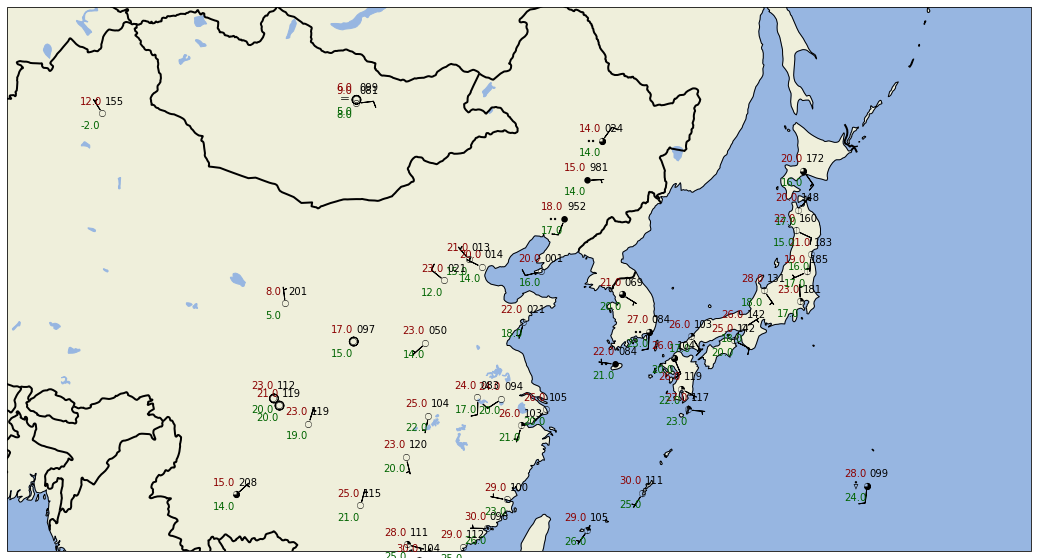

In [9]:
# 일기도 기입 설정
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots', length=5)
custom_layout.add_value('NW', 'air_temperature', fmt='.1f', units='degC', color='darkred', fontsize=10)
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.1f', units='degC',
                        color='darkgreen', fontsize=10)
custom_layout.add_value('NE', 'sea_level_pressure', fmt=lambda v: format(10 * v, '.0f')[-3:], units='mbar', color='black', fontsize=10)
custom_layout.add_symbol('W','present_weather', current_weather)
custom_layout.add_symbol('C','cloud_coverage', sky_cover, fontsize=7)


plt.rcParams['savefig.dpi'] = 255
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# 지도 성분 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# 위경도 설정
ax.set_extent((90, 150, 20, 50))


stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

custom_layout.plot(stationplot, data)

plt.show()